In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.stats import spearmanr
from catboost import CatBoostRegressor, Pool, cv,sum_models
from sklearn.model_selection import ParameterGrid,GridSearchCV,cross_validate
from sklearn.metrics import make_scorer, r2_score
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

数据导入

In [2]:
train_data = pd.read_pickle('data/train_data6.pkl')
test_data = pd.read_pickle('data/test_data6.pkl')

单因子测试

In [3]:
#单因子测试，绘制IC图，计算IC均值
from SingleFactorAnalysis import SingleFactorAnalysis
iclib = []
for factors in tqdm(train_data.columns[2:-1]):
    SFA = SingleFactorAnalysis(data=train_data,factor_col=factors)
    SFA.calcIC()
    #SFA.plotIC()
    iclib.append({
        'factor':factors,
        'RankICMean':SFA.icmean
    })

100%|██████████| 19/19 [02:50<00:00,  8.95s/it]


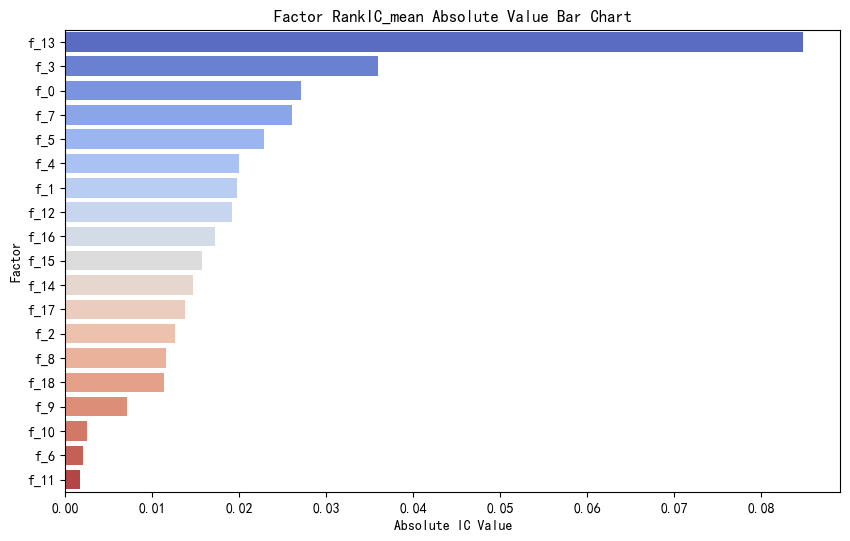

In [4]:
#绘制各个因子的IC均值
ic_df = pd.DataFrame(iclib)
ic_df["IC_abs"] = ic_df["RankICMean"].abs()
ic_df = ic_df.sort_values(by="IC_abs", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="IC_abs", y="factor", data=ic_df, palette="coolwarm")
plt.xlabel("Absolute IC Value")
plt.ylabel("Factor")
plt.title("Factor RankIC_mean Absolute Value Bar Chart")
plt.show()

In [5]:
#去除IC均值（绝对值）在0.01以下的因子
omit_factors = list(ic_df[ic_df['IC_abs']<=0.01].factor)
train_data.drop(omit_factors,axis=1,inplace=True)
test_data.drop(omit_factors,axis=1,inplace=True)

数据预处理

In [ ]:
#数据预处理：去极值、标准化
from DataProcessor import DataProcessor 
# params = [
#     {"class":'ToNum'},
#     {"class":'DropNa'},
#     {"class":'CSMidClipOutlier','field_group':'factor','params':5},
#     {"class":'CSZScoreNorm',"fields_group":'factor'},
#     {'class':'CSRankNorm','data_group':'train_valid_data','field_group':'label'}
# ]
params = [
    {"class":'ToNum'},
    {"class":'CSZFillNa'},
    {"class":'CSMidClipOutlier','field_group':'factor','params':5},
    {"class":'CSZScoreNorm',"fields_group":'factor'},
    {'class':'CSRankNorm','data_group':'train_valid_data','field_group':'label'}
]
DP = DataProcessor(train_valid_data=train_data,test_data=test_data,params=params)
possessed_train_data = DP.train_valid_data#.dropna()
#possessed_train_data.to_pickle('data/possessed_train_data6.pkl')
possessed_train_data.to_pickle('data/possessed_train_data6_1.pkl')
possessed_test_data = DP.test_data#.dropna()
# possessed_test_data.to_pickle('data/possessed_test_data6.pkl')
possessed_test_data.to_pickle('data/possessed_test_data6_1.pkl')

特征工程

KMO和巴特勒球形度检验 BartlettResult(statistic=5.077029244510833, pvalue=0.9847115173601334)
方差解释表
            特征根     方差百分比        累积
主成分1   3.389326  0.226037  0.226037
主成分2   2.339627  0.156032  0.382069
主成分3   2.070718  0.138098  0.520168
主成分4   1.729618  0.115350  0.635517
主成分5   1.277842  0.085221  0.720738
主成分6   1.113794  0.074280  0.795018
主成分7   0.852242  0.056837  0.851855
主成分8   0.548438  0.036576  0.888431
主成分9   0.440751  0.029394  0.917825
主成分10  0.353347  0.023565  0.941390
主成分11  0.258296  0.017226  0.958616
主成分12  0.239980  0.016004  0.974620
主成分13  0.165748  0.011054  0.985674
主成分14  0.155858  0.010394  0.996068
主成分15  0.058952  0.003932  1.000000


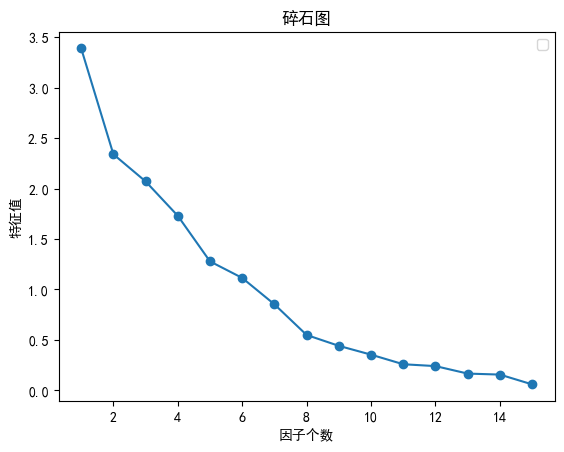

请输入选取的主成分数目：
成分矩阵表
             x1        x2        x3        x4        x5        x6        x7  \
主成分1   0.464245 -0.021985  0.029264  0.034607  0.436212  0.494712  0.007469   
主成分2   0.044953 -0.004501  0.459043  0.142159 -0.112857 -0.030992  0.297407   
主成分3   0.116230  0.593136 -0.111074 -0.436583 -0.083542  0.040431  0.388087   
主成分4   0.095997 -0.068725 -0.166127  0.289941 -0.123489 -0.000404  0.389375   
主成分5   0.127756  0.328286 -0.090240  0.361570 -0.152095  0.029224 -0.135388   
主成分6  -0.015351 -0.069981 -0.479411 -0.013367  0.012704 -0.007405  0.028361   
主成分7  -0.116334  0.141156 -0.005723  0.203105  0.079372 -0.256867  0.048667   
主成分8  -0.403087  0.092290 -0.088528  0.470493  0.500633  0.051436 -0.103449   
主成分9  -0.164960  0.247559  0.375092  0.146051  0.209745  0.019733  0.416788   
主成分10 -0.116856  0.008111 -0.308064  0.097971  0.149575 -0.005859  0.484387   
主成分11 -0.337326 -0.037563 -0.083035 -0.510139  0.477047 -0.097960  0.003012   
主成分12  0.067947  0.084944 -0.5096

'主成分分析已完成'

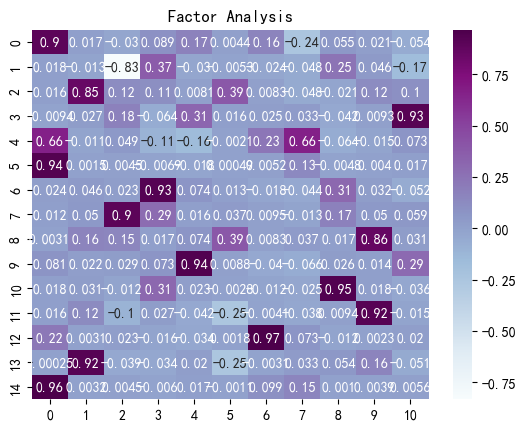

In [14]:
from PCA import PCA_analysis
pca = PCA_analysis(possessed_train_data.iloc[:,:-1])
pca.run()

调参

In [ ]:
#设置交叉验证调参及参数空间
from ParamsTuning import BaseTuneParams
class CatBoostCVTuneParams(BaseTuneParams):
    def __init__(self, X, y,cv = 5,params=None,params_dict=None):
        super().__init__(X, y)
        self.cv = cv
        if params is None:
            params = {
                'loss_function': 'RMSE',
                'eval_metric': 'RMSE',
                'iterations': 50,
                'learning_rate': 0.1,
                'depth': 4,
                'subsample': 0.6,
                'random_seed': 123,
                'l2_leaf_reg': 5,
                'bootstrap_type': 'Bernoulli',
                'sampling_frequency': 'PerTree',
                'grow_policy': 'SymmetricTree',
                'min_data_in_leaf': 500,
                'one_hot_max_size': 4,
                'nan_mode': 'Max',
                'boosting_type': 'Ordered',
                'max_ctr_complexity': 2,
                'logging_level': 'Silent',
                'border_count': 254,
                'feature_border_type': 'GreedyLogSum',
                'task_type':'GPU',
                'devices':'0',
                "early_stopping_rounds":50,
            }
        self.params = params
        if params_dict is None:
            params_dict = {
                'iterations': (50, 300),
                'learning_rate': (0.01, 0.2),
                'depth': (3, 10),
                'subsample': (0.6, 1.0),
            }
        self.params_dict = params_dict
        
        self.tp = BaseTuneParams.BysOpt(self.catboost_cv,self.params_dict)
        self.best_params = self.tp.max.get('params')

    def catboost_cv(self,iterations, learning_rate, depth, subsample):
        self.params.update({'iterations':int(iterations),'depth':int(depth),'learning_rate':learning_rate,'subsample':subsample})
        model = CatBoostRegressor(**self.params)
        scores = cross_validate(
            model, self.X, self.y, cv=self.cv, scoring=make_scorer(r2_score), return_train_score=True
        )
        return np.mean(scores['test_score'])

In [ ]:
#借助kaggle在线GPU算力调参
X = pca.data_dr.values
y = possessed_train_data['y'].values
catcv_tuning = CatBoostCVTuneParams(X,y)
best_params = catcv_tuning.best_params
'''
best_params = {'depth': 9.688194509178077,
    'iterations': 179.23735103542296,
    'learning_rate': 0.07401779765659318,
    'subsample': 0.9457439157506488}
'''
'''
#2025-04-01 调整数据处理方式
best_params = {'depth': 9.914815735722868,
 'iterations': 228.20895032123022,
 'learning_rate': 0.05823619953836616,
 'subsample': 0.700843098706332}
'''

模型训练与预测

In [ ]:
from Model import Model
class CatBoostModel(Model):
    def __init__(self,batch_size=None,**kwargs):
        self.batch_size = batch_size
        self._params = {
                'loss_function': 'RMSE',
                'eval_metric': 'RMSE',
                'iterations': 50,
                'learning_rate': 0.1,
                'depth': 4,
                'subsample': 0.6,
                'random_seed': 123,
                'l2_leaf_reg': 5,
                'bootstrap_type': 'Bernoulli',
                'sampling_frequency': 'PerTree',
                'grow_policy': 'SymmetricTree',
                'min_data_in_leaf': 500,
                'one_hot_max_size': 4,
                'nan_mode': 'Max',
                'boosting_type': 'Ordered',
                'max_ctr_complexity': 2,
                'logging_level': 'Silent',
                'border_count': 254,
                'feature_border_type': 'GreedyLogSum',
                # 'task_type':'GPU',
                # 'devices':'0',
                "early_stopping_rounds":50,
            }
        self._params.update(kwargs)
        self.model = None
    def fit(self,dataset):
        X = dataset.get('X')
        y = dataset.get('y')
        if self.batch_size is not None:
            self.batch_fit(X,y)
            return
        self.model = CatBoostRegressor(**self._params)
        self.model.fit(X,y)
        current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        model_save_path = os.path.join('models',f'CatBoost_{current}.cb')
        self.model.save_model(model_save_path)
        return
    def batch_fit(self,X,y,train_test_split = 0.2):
        '''
        X and y have multi index
        level 0: date
        level 1: code
        '''
        data = pd.concat([X,y],axis=1)
        unique_dates = sorted(data.index.get_level_values(0).unique())
        models = []
        print('Begin Batch Training:')
        for i in tqdm(range(0,len(unique_dates),self.batch_size)):
            batch_dates = unique_dates[i:i+self.batch_size]
            batch_data = data.loc[data.index.get_level_values(0).isin(batch_dates)]
            if batch_data.empty:
                print(f'No data for batch {i//self.batch_size}.')
            train_mask = (np.random.rand(len(batch_data)) > train_test_split)
            val_mask = ~train_mask
            train_X = batch_data.iloc[train_mask,:-1]
            val_X = batch_data.iloc[val_mask,:-1]
            train_y = batch_data.iloc[train_mask,-1]
            val_y = batch_data.iloc[val_mask,-1]
            train_pool = Pool(train_X,label=train_y)
            val_pool = Pool(val_X,label=val_y)
            if models:
                train_pool.set_baseline(models[-1].predict(train_pool))
                val_pool.set_baseline(models[-1].predict(val_pool))
            model = CatBoostRegressor(**self._params)
            model.fit(train_pool,eval_set=val_pool,early_stopping_rounds=10)
            models.append(model)
        print('Finish Batch Training.')
        self.model = sum_models(models)
        current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        model_save_path = os.path.join('models',f'CatBoost_batch_{current}.cb')
        self.model.save_model(model_save_path)
        return
    def predict(self,dataset):
        if self.model is None:
            raise ValueError("model is not fitted yet!")
        X_test = dataset.get('X_test')
        self.y_pred = pd.DataFrame(self.model.predict(X_test.values),index = X_test.index)
        return

In [ ]:
'''
模型训练与预测
'''
k = 11
X_test = possessed_test_data @ pca.components.iloc[0:k,:].T.values
X_test.columns = pca.data_dr.columns #准备处理后测试集数据
dataset = {
    'X':pca.data_dr,
    'y':possessed_train_data['y'],
    'X_test':X_test
    } #准备数据
# best_params = {'depth': 10,
#     'iterations': 179,
#     'learning_rate': 0.074,
#     'subsample': 0.95
#     } #准备参数
best_params = {'depth': 10,
    'iterations': 228,
    'learning_rate': 0.05823619953836616,
    'subsample': 0.70
    } #准备参数
model = CatBoostModel(batch_size=100,**best_params)
model.fit(dataset) #模型训练
model.predict(dataset) #模型预测

In [ ]:
#保存结果
'''
第一次跑:2025-03-31
'''
y_pred = model.y_pred
y_pred.columns = ['y_pred']
y_pred.reset_index(inplace=True)
y_pred.index.name = 'id'
#y_pred.to_csv('result/y_pred.csv')

y_pred2 = pd.merge(left=test_data,right=y_pred,on=['date','code'],how='left')
y_pred2 = y_pred2[['code','date','y_pred']]
y_pred2.fillna(0,inplace=True)
y_pred2['id'] = y_pred2.index
y_pred2.to_csv('result/y_pred_20250331.csv')
'''
最终得分: 0.0618032338
'''

'''
第二次跑:改进数据处理方式,2025-04-01
'''
y_pred = model.y_pred
y_pred.columns = ['y_pred']
y_pred.reset_index(inplace=True)
y_pred['id'] = y_pred.index
y_pred.to_csv('result/y_pred_20250401.csv')